In [1]:
!pip install pymc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
%tensorflow_version 2.x
import pandas as pd
import numpy as np
import pymc as pm
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import shapiro
from scipy.stats import normaltest
import time

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [21]:
from scipy.stats import f
import matplotlib.pyplot as plot
import seaborn as sns
from sklearn.mixture import GaussianMixture
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from tensorflow.keras.optimizers import RMSprop, Adam, SGD

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
# Load the stock return data
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/[COM502] Term paper/return_full.csv')

In [5]:
# Update the file path accordingly

# Data preprocessing
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(data['V1'].values.reshape(-1, 1))

# Divide the data into two groups based on Gaussianity test
def divide_data(data, interval):
    groups = []
    for i in range(0, len(data), interval):
        group = data[i:i+interval]
        # Perform Gaussianity test
        _, p_value = normaltest(group.flatten())

        # Perform Gaussianity test (Shapiro-Wilk test)
        #_, p_value = shapiro(group.flatten())

        is_gaussian = p_value > 0.05  # Set the threshold as needed
        groups.append({'data': group, 'is_gaussian': is_gaussian, 'p_value': p_value})
    return groups

# Define the interval for dividing the data into groups
interval = 60  # Adjust this as needed

# Divide the data into two groups
groups = divide_data(scaled_data, interval)



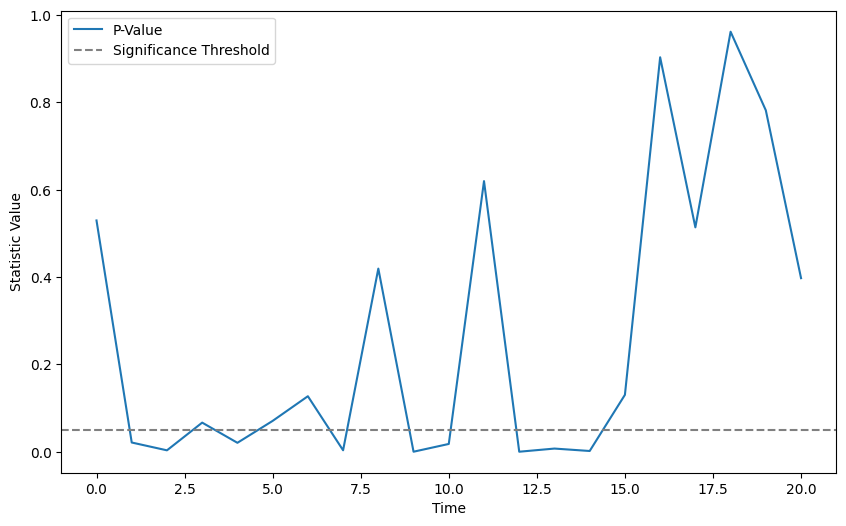

In [6]:
#Check divided groups by p-value
df = pd.DataFrame(groups)

# Plot the results
fig, ax = plot.subplots(figsize = (10, 6))
ax.plot(df.index, df["p_value"], label='P-Value')
ax.axhline(y=0.05, linestyle='--', color='gray', label='Significance Threshold')
ax.set_xlabel('Time')
ax.set_ylabel('Statistic Value')
ax.legend()
plot.show()

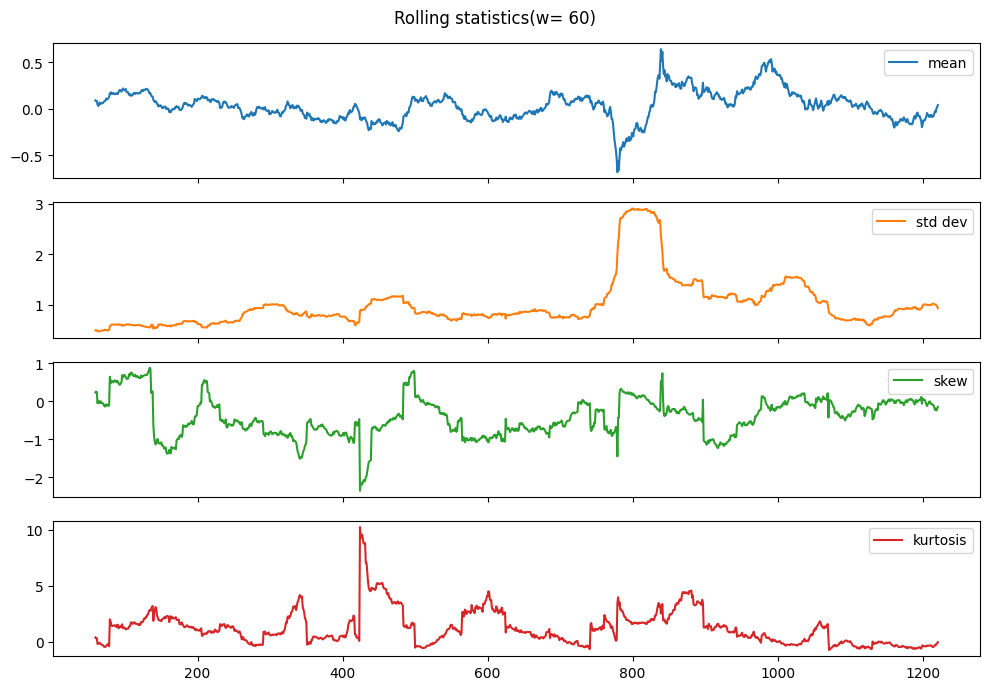

In [8]:
#Higher moments

w= interval 

for x in range(0, len(data), len(data)):
    start = x
    end = x + len(data)
    temp = data[(data.index >= start) & (data.index  < end)]  

    s1 = temp['V1'].rolling(w).mean()
    s2 = temp['V1'].rolling(w).std()
    s3 = temp['V1'].rolling(w).skew()  #skewedness = 0
    s4 = temp['V1'].rolling(w).kurt()  #kurtosis = 3  
    signals = pd.concat([s1, s2, s3, s4], axis=1)
    signals.columns = ['mean', 'std dev', 'skew', 'kurtosis']
    signals.plot(title="Rolling statistics(w= "+ str(w) + ")", subplots=True, figsize=(10,7));
    plot.tight_layout()
    plot.show

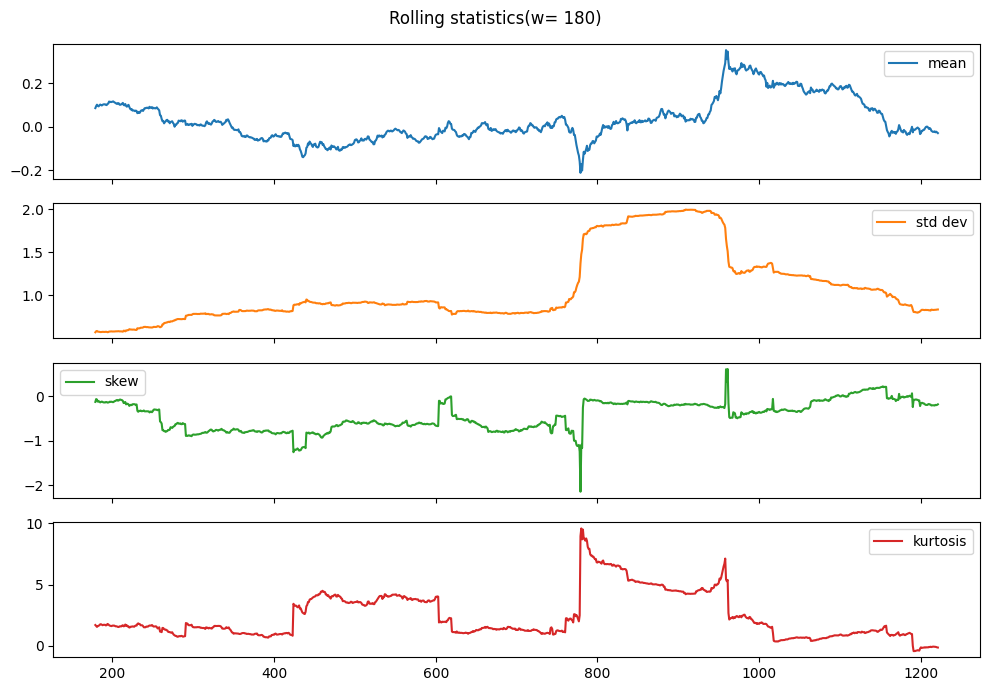

In [26]:
#Higher moments

w= 180

for x in range(0, len(data), len(data)):
    start = x
    end = x + len(data)
    temp = data[(data.index >= start) & (data.index  < end)]  

    s1 = temp['V1'].rolling(w).mean()
    s2 = temp['V1'].rolling(w).std()
    s3 = temp['V1'].rolling(w).skew()  #skewedness = 0
    s4 = temp['V1'].rolling(w).kurt()  #kurtosis = 3  
    signals = pd.concat([s1, s2, s3, s4], axis=1)
    signals.columns = ['mean', 'std dev', 'skew', 'kurtosis']
    signals.plot(title="Rolling statistics(w= "+ str(w) + ")", subplots=True, figsize=(10,7));
    plot.tight_layout()
    plot.show

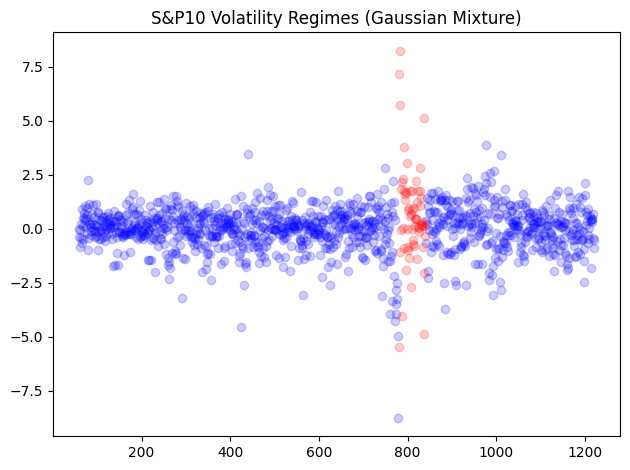

In [9]:
w = interval
vol = data['V1'].rolling(w).std()
vol = vol.dropna()

labels = GaussianMixture(2).fit_predict(vol.values.reshape(-1, 1))

prices = data['V1'].reindex(vol.index)
prices[labels == 0].plot(style='bo', alpha=0.2)
prices[labels == 1].plot(subplots = True, style='ro', alpha=0.2)
#prices[labels == 2].plot(subplots = True, style='ro', alpha=0.2)
plot.title('S&P10 Volatility Regimes (Gaussian Mixture)')
plot.tight_layout()

<ipython-input-10-91fd899b5eb9>:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prices[labels == 0])
<ipython-input-10-91fd899b5eb9>:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(prices[labels == 1])


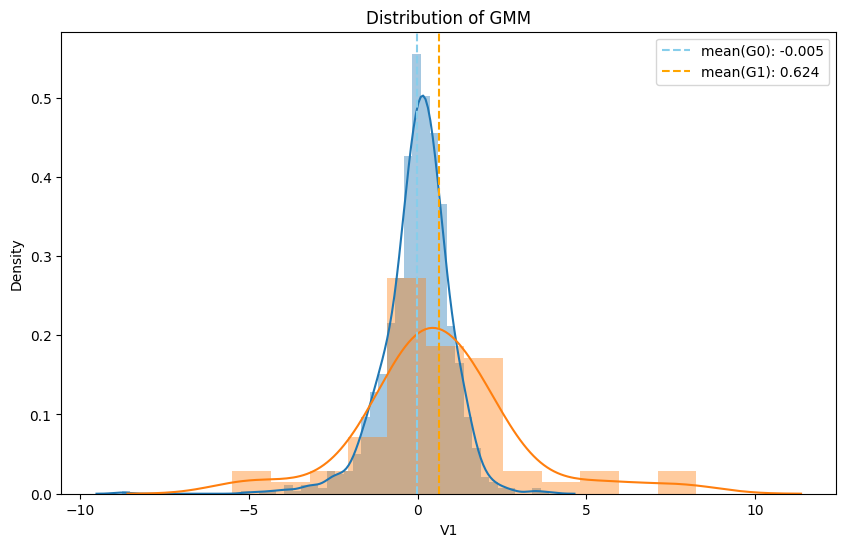

In [10]:
#label==0, label==1에 대한 분포

fig, ax = plot.subplots(figsize = (10, 6))

mean1 = prices[labels == 0].mean()
mean2 = prices[labels == 1].mean()

sns.distplot(prices[labels == 0])
sns.distplot(prices[labels == 1])

ax.legend(fontsize=12, loc='upper left') # legend position
plot.title('Distribution of GMM')
ax.axvline(x= mean1, linestyle='--', color='skyblue', label='mean(G0): ' + str(round(mean1,3)))
ax.axvline(x= mean2, linestyle='--', color='orange', label='mean(G1): ' + str(round(mean2,3)))
ax.legend()
plot.show()

In [13]:
# Function to create sequences and labels for RNN and LSTM
def create_sequences_and_labels(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Define the sequence length for RNN and LSTM
sequence_length = 10  # Adjust this as needed

# Create empty lists to store the losses and computation times
rnn_losses = []
lstm_losses = []
ngp_losses = []
losses = []
gru_losses = []
rnn_times = []
lstm_times = []
ngp_times = []
times = []
gru_times = []

# Train and evaluate the models for each group
for group in groups:
    group_data = group['data']
    is_gaussian = group['is_gaussian']
    
    if is_gaussian:
        # Train and evaluate the near-Gaussian process model
        start_time = time.time()

        # Fit the linear regression model
        X = np.arange(len(group_data))
        X = sm.add_constant(X)
        model = sm.OLS(group_data, X)
        results = model.fit()
        
        end_time = time.time()
        computation_time = end_time - start_time
        
        # Calculate the mean squared error loss for the OLS model
        predictions = results.predict(X)
        loss = np.mean((group_data - predictions)**2)
        
        losses.append(loss)
        times.append(computation_time)

        
    else:
        # Train and evaluate the non-Gaussian process model with MCMC
        start_time = time.time()

        #The MCMC sampling is not required for the piecewise model, 
        #as it is used in Bayesian inference to estimate the posterior distribution of the model parameters.
        #In the piecewise model, we assume the parameters (alpha, beta, sigma) are fixed and known. 
        #Therefore, we don't need to estimate their posterior distribution using MCMC. Instead, we can directly calculate the mean
        
        with pm.Model() as model_ngp:
            # Priors for the near-Gaussian process parameters
            alpha = pm.Normal('alpha', mu=0, sigma=1)
            beta = pm.Normal('beta', mu=0, sigma=1)

            # Define the near-Gaussian process model
            mu = alpha + beta * np.arange(len(group_data))
            sigma = pm.HalfNormal('sigma', sigma=1)
            returns = pm.Normal('returns', mu=mu, sigma=sigma, observed=group_data.flatten())

            # Run the model
            #runs the Markov Chain Monte Carlo (MCMC) sampling algorithm to estimate the posterior distribution of the model parameters. 
            trace_ngp = pm.sample(2000, tune=1000) 
        
        end_time = time.time()
        computation_time = end_time - start_time
        
        # Calculate the mean squared error loss for the near-Gaussian process model
        returns_mean = trace_ngp.observed_data['returns'].mean().values
        ngp_loss = np.mean((group_data.flatten() - returns_mean)**2)
        
        ngp_losses.append(ngp_loss)
        ngp_times.append(computation_time)


        # Create sequences and labels for RNN and LSTM
        X, y = create_sequences_and_labels(group_data, sequence_length)
        
        # Train and evaluate the RNN model
        start_time = time.time()
        
        model_rnn = Sequential()
        model_rnn.add(SimpleRNN(32, input_shape=(sequence_length, 1)))
        model_rnn.add(Dense(1))
        model_rnn.compile(optimizer='adam', loss='mse')
        model_rnn.fit(X, y, epochs=10, batch_size=32)
        rnn_loss = model_rnn.evaluate(X, y)
        
        end_time = time.time()
        computation_time = end_time - start_time
        
        rnn_losses.append(rnn_loss)
        rnn_times.append(computation_time)
        
        # Train and evaluate the LSTM model
        start_time = time.time()
        
        model_lstm = Sequential()
        model_lstm.add(LSTM(32, input_shape=(sequence_length, 1)))
        model_lstm.add(Dense(1))
        model_lstm.compile(optimizer='adam', loss='mse')
        model_lstm.fit(X, y, epochs=10, batch_size=32)
        lstm_loss = model_lstm.evaluate(X, y)
        
        end_time = time.time()
        computation_time = end_time - start_time
        
        lstm_losses.append(lstm_loss)
        lstm_times.append(computation_time)


        # Train and evaluate the GRU model
        start_time = time.time()
        
        model_gru = Sequential()
        model_gru.add(GRU(32, input_shape=(sequence_length, 1)))
        model_gru.add(Dense(1))
        model_gru.compile(optimizer='adam', loss='mse')
        model_gru.fit(X, y, epochs=10, batch_size=32)
        gru_loss = model_gru.evaluate(X, y)
        
        end_time = time.time()
        computation_time = end_time - start_time
        
        gru_losses.append(gru_loss)
        gru_times.append(computation_time)

# Perform comparison and analysis
avg_rnn_loss = np.mean(rnn_losses)
avg_lstm_loss = np.mean(lstm_losses)
avg_ngp_loss = np.mean(ngp_losses)
avg_gp_loss = np.mean(losses)
avg_gru_loss = np.mean(gru_losses)

avg_rnn_time = np.mean(rnn_times)
avg_lstm_time = np.mean(lstm_times)
avg_ngp_time = np.mean(ngp_times)
avg_gp_time = np.mean(times)
avg_gru_time = np.mean(gru_times)

print("Average RNN Loss:", avg_rnn_loss)
print("Average LSTM Loss:", avg_lstm_loss)
print("Average Non-Gaussian Process Loss:", avg_ngp_loss)
print("Average Near-Gaussian Process Loss:", avg_gp_loss)
print("Average GRU Loss:", avg_gru_loss)

print("Average RNN Computation Time:", avg_rnn_time)
print("Average LSTM Computation Time:", avg_lstm_time)
print("Average Non-Gaussian Process Computation Time:", avg_ngp_time)
print("Average Near-Gaussian Process Computation Time:", avg_gp_time)
print("Average GRU Computation Time:", avg_gru_time)


Epoch 1/10
2/2 [==============================] - 2s 10ms/step - loss: 0.0198
Epoch 2/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0071
Epoch 3/10
2/2 [==============================] - 0s 12ms/step - loss: 0.0080
Epoch 4/10
2/2 [==============================] - 0s 12ms/step - loss: 0.0083
Epoch 5/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0066
Epoch 6/10
2/2 [==============================] - 0s 15ms/step - loss: 0.0055
Epoch 7/10
2/2 [==============================] - 0s 17ms/step - loss: 0.0051
Epoch 8/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0052
Epoch 9/10
2/2 [==============================] - 0s 13ms/step - loss: 0.0054
Epoch 10/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0051
Epoch 1/10
2/2 [==============================] - 2s 12ms/step - loss: 0.0068
Epoch 2/10
2/2 [==============================] - 0s 12ms/step - loss: 0.0052
Epoch 3/10
2/2 [==============================] - 0s 11ms/step - 

2/2 [==============================] - 0s 8ms/step - loss: 0.0049


Epoch 1/10
2/2 [==============================] - 2s 12ms/step - loss: 0.0229
Epoch 2/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0143
Epoch 3/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0108
Epoch 4/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 5/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0078
Epoch 6/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0075
Epoch 7/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0071
Epoch 8/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0069
Epoch 9/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0069
Epoch 10/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0067


2/2 [==============================] - 0s 11ms/step - loss: 0.0066
Epoch 1/10
2/2 [==============================] - 3s 14ms/step - loss: 0.0072
Epoch 2/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0064
Epoch 3/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 4/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0060
Epoch 5/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 6/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0062
Epoch 7/10
2/2 [==============================] - 0s 12ms/step - loss: 0.0062
Epoch 8/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 9/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0061
Epoch 10/10
2/2 [==============================] - 1s 8ms/step - loss: 0.0060
Epoch 1/10
2/2 [==============================] - 2s 14ms/step - loss: 0.0065
Epoch 2/10
2/2 [==============================] - 0s 10ms/step - loss: 0.00

Epoch 1/10
2/2 [==============================] - 1s 10ms/step - loss: 0.0371
Epoch 2/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0299
Epoch 3/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0257
Epoch 4/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0218
Epoch 5/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0193
Epoch 6/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0175
Epoch 7/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0160
Epoch 8/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0150
Epoch 9/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0144
Epoch 10/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0137
Epoch 1/10
2/2 [==============================] - 3s 12ms/step - loss: 0.0156
Epoch 2/10
2/2 [==============================] - 0s 12ms/step - loss: 0.0154
Epoch 3/10
2/2 [==============================] - 0s 13ms/step - los

Epoch 1/10
2/2 [==============================] - 1s 10ms/step - loss: 0.0208
Epoch 2/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0171
Epoch 3/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0158
Epoch 4/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0149
Epoch 5/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0145
Epoch 6/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0140
Epoch 7/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0136
Epoch 8/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0132
Epoch 9/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0130
Epoch 10/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0127
Epoch 1/10
2/2 [==============================] - 2s 12ms/step - loss: 0.0148
Epoch 2/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0144
Epoch 3/10
2/2 [==============================] - 0s 11ms/step - loss

Epoch 1/10
2/2 [==============================] - 1s 10ms/step - loss: 0.0132
Epoch 2/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0111
Epoch 3/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0098
Epoch 4/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0092
Epoch 5/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 6/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0084
Epoch 7/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0082
Epoch 8/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0079
Epoch 9/10
2/2 [==============================] - 0s 12ms/step - loss: 0.0077
Epoch 10/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0073
Epoch 1/10
2/2 [==============================] - 2s 13ms/step - loss: 0.0086
Epoch 2/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0084
Epoch 3/10
2/2 [==============================] - 0s 11ms/step - loss

Epoch 1/10
2/2 [==============================] - 1s 9ms/step - loss: 0.0316
Epoch 2/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0205
Epoch 3/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0148
Epoch 4/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0111
Epoch 5/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0091
Epoch 6/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0084
Epoch 7/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0085
Epoch 8/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0091
Epoch 9/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0089
Epoch 10/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0084
Epoch 1/10
2/2 [==============================] - 2s 12ms/step - loss: 0.0114
Epoch 2/10
2/2 [==============================] - 0s 12ms/step - loss: 0.0106
Epoch 3/10
2/2 [==============================] - 0s 11ms/step - lo

Epoch 1/10
2/2 [==============================] - 2s 10ms/step - loss: 0.0620
Epoch 2/10
2/2 [==============================] - 0s 12ms/step - loss: 0.0549
Epoch 3/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0532
Epoch 4/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0501
Epoch 5/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0484
Epoch 6/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0477
Epoch 7/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0474
Epoch 8/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0463
Epoch 9/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0456
Epoch 10/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0450
Epoch 1/10
2/2 [==============================] - 2s 15ms/step - loss: 0.0770
Epoch 2/10
2/2 [==============================] - 0s 14ms/step - loss: 0.0738
Epoch 3/10
2/2 [==============================] - 0s 13ms/step - l

Epoch 1/10
2/2 [==============================] - 1s 11ms/step - loss: 0.0658
Epoch 2/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0492
Epoch 3/10
2/2 [==============================] - 0s 12ms/step - loss: 0.0438
Epoch 4/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0407
Epoch 5/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0381
Epoch 6/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0363
Epoch 7/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0352
Epoch 8/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0353
Epoch 9/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0341
Epoch 10/10
2/2 [==============================] - 0s 8ms/step - loss: 0.0330
Epoch 1/10
2/2 [==============================] - 2s 19ms/step - loss: 0.0434
Epoch 2/10
2/2 [==============================] - 0s 12ms/step - loss: 0.0407
Epoch 3/10
2/2 [==============================] - 0s 11ms/step - los

Epoch 1/10
2/2 [==============================] - 1s 11ms/step - loss: 0.0507
Epoch 2/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0373
Epoch 3/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0298
Epoch 4/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0249
Epoch 5/10
2/2 [==============================] - 0s 11ms/step - loss: 0.0238
Epoch 6/10
2/2 [==============================] - 0s 10ms/step - loss: 0.0244
Epoch 7/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0237
Epoch 8/10
2/2 [==============================] - 0s 9ms/step - loss: 0.0217
Epoch 9/10
2/2 [==============================] - 0s 13ms/step - loss: 0.0201
Epoch 10/10
2/2 [==============================] - 0s 7ms/step - loss: 0.0179
Epoch 1/10
2/2 [==============================] - 2s 16ms/step - loss: 0.0221
Epoch 2/10
2/2 [==============================] - 0s 14ms/step - loss: 0.0200
Epoch 3/10
2/2 [==============================] - 0s 14ms/step - l

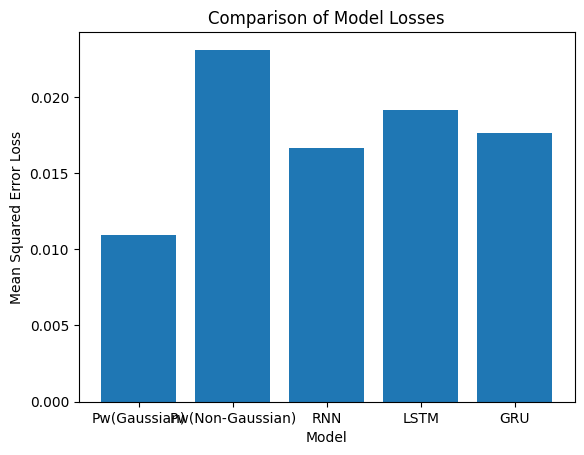

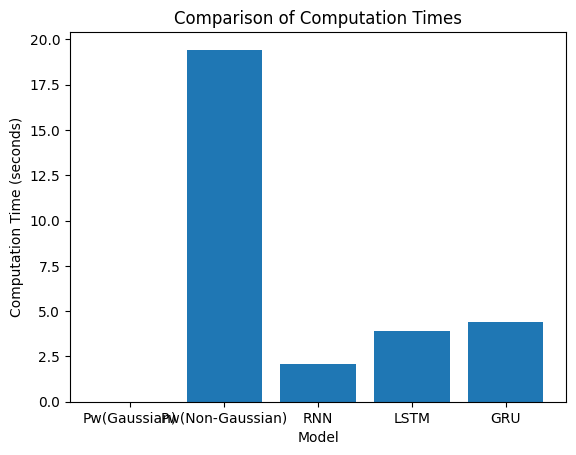

In [16]:
# Define the model losses and computation times
model_names = ['Pw(Gaussian)','Pw(Non-Gaussian)', 'RNN', 'LSTM', 'GRU']

losses = [avg_gp_loss, avg_ngp_loss, avg_rnn_loss, avg_lstm_loss, avg_gru_loss]
times = [avg_gp_time, avg_ngp_time, avg_rnn_time, avg_lstm_time, avg_gru_time]

# Plot the model losses
#plot.figure(figsize=(10, 6))
plot.figure()
plot.bar(model_names, losses)
plot.xlabel('Model')
plot.ylabel('Mean Squared Error Loss')
plot.title('Comparison of Model Losses')
plot.show()

# Plot the computation times
#plot.figure(figsize=(10, 6))
plot.figure()
plot.bar(model_names, times)
plot.xlabel('Model')
plot.ylabel('Computation Time (seconds)')
plot.title('Comparison of Computation Times')
plot.show()

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0383
Epoch 2/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0246
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0175
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0135
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0110
Epoch 6/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0093
Epoch 7/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0080
Epoch 8/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0070
Epoch 9/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0062
Epoch 10/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0054
Epoch 11/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0047
Epoch 12/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0041
Epoch 13/100
1/1 [==============================] -

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0292
Epoch 2/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0225
Epoch 3/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0179
Epoch 4/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0145
Epoch 5/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0119
Epoch 6/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0099
Epoch 7/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0084
Epoch 8/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0072
Epoch 9/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0064
Epoch 10/100
1/1 [==============================] - 0s 14ms/step - loss: 0.0058
Epoch 11/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0054
Epoch 12/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0050
Epoch 13/100
1/1 [==============================] -

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0773
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0558
Epoch 3/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0425
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0344
Epoch 5/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0293
Epoch 6/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0252
Epoch 7/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0217
Epoch 8/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0188
Epoch 9/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0165
Epoch 10/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0149
Epoch 11/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0138
Epoch 12/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0130
Epoch 13/100
1/1 [==============================] -

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0575
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0447
Epoch 3/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0367
Epoch 4/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0309
Epoch 5/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0266
Epoch 6/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0238
Epoch 7/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0218
Epoch 8/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0200
Epoch 9/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0184
Epoch 10/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0170
Epoch 11/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0158
Epoch 12/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0148
Epoch 13/100
1/1 [==============================] -

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0561
Epoch 2/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0355
Epoch 3/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0230
Epoch 4/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0167
Epoch 5/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0130
Epoch 6/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0098
Epoch 7/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0076
Epoch 8/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0068
Epoch 9/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0070
Epoch 10/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0070
Epoch 11/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0064
Epoch 12/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0054
Epoch 13/100
1/1 [==============================] -

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.0547
Epoch 2/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0409
Epoch 3/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0330
Epoch 4/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0272
Epoch 5/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0221
Epoch 6/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0181
Epoch 7/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0155
Epoch 8/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0138
Epoch 9/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0125
Epoch 10/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0113
Epoch 11/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0103
Epoch 12/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0094
Epoch 13/100
1/1 [==============================] -

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.1160
Epoch 2/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0964
Epoch 3/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0813
Epoch 4/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0696
Epoch 5/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0604
Epoch 6/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0529
Epoch 7/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0464
Epoch 8/100
1/1 [==============================] - 0s 15ms/step - loss: 0.0408
Epoch 9/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0366
Epoch 10/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0329
Epoch 11/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0289
Epoch 12/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0258
Epoch 13/100
1/1 [==============================] -

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 0.0751
Epoch 2/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0603
Epoch 3/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0553
Epoch 4/100
1/1 [==============================] - 0s 20ms/step - loss: 0.0525
Epoch 5/100
1/1 [==============================] - 0s 27ms/step - loss: 0.0497
Epoch 6/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0468
Epoch 7/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0442
Epoch 8/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0417
Epoch 9/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0395
Epoch 10/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0379
Epoch 11/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0367
Epoch 12/100
1/1 [==============================] - 0s 16ms/step - loss: 0.0359
Epoch 13/100
1/1 [==============================] -

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.0570
Epoch 2/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0459
Epoch 3/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0403
Epoch 4/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0362
Epoch 5/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0321
Epoch 6/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0288
Epoch 7/100
1/1 [==============================] - 0s 18ms/step - loss: 0.0265
Epoch 8/100
1/1 [==============================] - 0s 21ms/step - loss: 0.0249
Epoch 9/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0235
Epoch 10/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0220
Epoch 11/100
1/1 [==============================] - 0s 19ms/step - loss: 0.0205
Epoch 12/100
1/1 [==============================] - 0s 17ms/step - loss: 0.0191
Epoch 13/100
1/1 [==============================] -

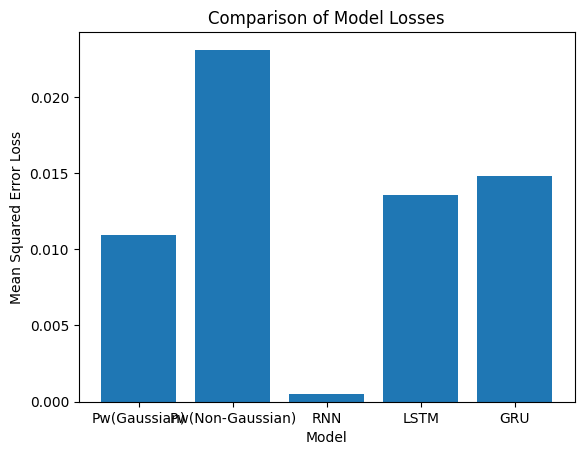

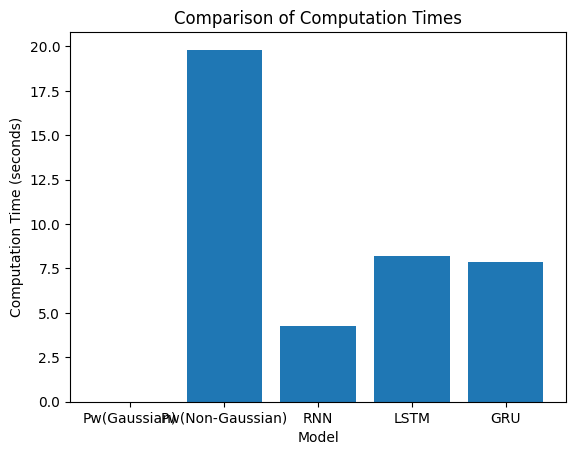

In [18]:
#@title Changing sequential, epocs...
# Function to create sequences and labels for RNN and LSTM
def create_sequences_and_labels(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Define the sequence length for RNN and LSTM
sequence_length = 30  # Adjust this as needed

# Create empty lists to store the losses and computation times
rnn_losses = []
lstm_losses = []
ngp_losses = []
losses = []
gru_losses = []
rnn_times = []
lstm_times = []
ngp_times = []
times = []
gru_times = []

# Train and evaluate the models for each group
for group in groups:
    group_data = group['data']
    is_gaussian = group['is_gaussian']
    
    if is_gaussian:
        # Train and evaluate the near-Gaussian process model
        start_time = time.time()

        # Fit the linear regression model
        X = np.arange(len(group_data))
        X = sm.add_constant(X)
        model = sm.OLS(group_data, X)
        results = model.fit()
        
        end_time = time.time()
        computation_time = end_time - start_time
        
        # Calculate the mean squared error loss for the OLS model
        predictions = results.predict(X)
        loss = np.mean((group_data - predictions)**2)
        
        losses.append(loss)
        times.append(computation_time)

        
    else:
        # Train and evaluate the non-Gaussian process model with MCMC
        start_time = time.time()

        #The MCMC sampling is not required for the piecewise model, 
        #as it is used in Bayesian inference to estimate the posterior distribution of the model parameters.
        #In the piecewise model, we assume the parameters (alpha, beta, sigma) are fixed and known. 
        #Therefore, we don't need to estimate their posterior distribution using MCMC. Instead, we can directly calculate the mean
        
        with pm.Model() as model_ngp:
            # Priors for the near-Gaussian process parameters
            alpha = pm.Normal('alpha', mu=0, sigma=1)
            beta = pm.Normal('beta', mu=0, sigma=1)

            # Define the near-Gaussian process model
            mu = alpha + beta * np.arange(len(group_data))
            sigma = pm.HalfNormal('sigma', sigma=1)
            returns = pm.Normal('returns', mu=mu, sigma=sigma, observed=group_data.flatten())

            # Run the model
            #runs the Markov Chain Monte Carlo (MCMC) sampling algorithm to estimate the posterior distribution of the model parameters. 
            trace_ngp = pm.sample(2000, tune=1000) 
        
        end_time = time.time()
        computation_time = end_time - start_time
        
        # Calculate the mean squared error loss for the near-Gaussian process model
        returns_mean = trace_ngp.observed_data['returns'].mean().values
        ngp_loss = np.mean((group_data.flatten() - returns_mean)**2)
        
        ngp_losses.append(ngp_loss)
        ngp_times.append(computation_time)


        # Create sequences and labels for RNN and LSTM
        X, y = create_sequences_and_labels(group_data, sequence_length)
        
        # Train and evaluate the RNN model
        start_time = time.time()
        
        model_rnn = Sequential()
        model_rnn.add(SimpleRNN(32, input_shape=(sequence_length, 1)))
        model_rnn.add(Dense(1))
        model_rnn.compile(optimizer='adam', loss='mse')
        model_rnn.fit(X, y, epochs=100, batch_size=32)
        rnn_loss = model_rnn.evaluate(X, y)
        
        end_time = time.time()
        computation_time = end_time - start_time
        
        rnn_losses.append(rnn_loss)
        rnn_times.append(computation_time)
        
        # Train and evaluate the LSTM model
        start_time = time.time()
        
        model_lstm = Sequential()
        model_lstm.add(LSTM(32, input_shape=(sequence_length, 1)))
        model_lstm.add(Dense(1))
        model_lstm.compile(optimizer='adam', loss='mse')
        model_lstm.fit(X, y, epochs=100, batch_size=32)
        lstm_loss = model_lstm.evaluate(X, y)
        
        end_time = time.time()
        computation_time = end_time - start_time
        
        lstm_losses.append(lstm_loss)
        lstm_times.append(computation_time)


        # Train and evaluate the GRU model
        start_time = time.time()
        
        model_gru = Sequential()
        model_gru.add(GRU(32, input_shape=(sequence_length, 1)))
        model_gru.add(Dense(1))
        model_gru.compile(optimizer='adam', loss='mse')
        model_gru.fit(X, y, epochs=100, batch_size=32)
        gru_loss = model_gru.evaluate(X, y)
        
        end_time = time.time()
        computation_time = end_time - start_time
        
        gru_losses.append(gru_loss)
        gru_times.append(computation_time)

# Perform comparison and analysis
avg_rnn_loss = np.mean(rnn_losses)
avg_lstm_loss = np.mean(lstm_losses)
avg_ngp_loss = np.mean(ngp_losses)
avg_gp_loss = np.mean(losses)
avg_gru_loss = np.mean(gru_losses)

avg_rnn_time = np.mean(rnn_times)
avg_lstm_time = np.mean(lstm_times)
avg_ngp_time = np.mean(ngp_times)
avg_gp_time = np.mean(times)
avg_gru_time = np.mean(gru_times)


print("Average Near-Gaussian Process Loss:", avg_gp_loss)
print("Average Non-Gaussian Process Loss:", avg_ngp_loss)
print("Average RNN Loss:", avg_rnn_loss)
print("Average LSTM Loss:", avg_lstm_loss)
print("Average GRU Loss:", avg_gru_loss)

print("Average Near-Gaussian Process Computation Time:", avg_gp_time)
print("Average Non-Gaussian Process Computation Time:", avg_ngp_time)
print("Average RNN Computation Time:", avg_rnn_time)
print("Average LSTM Computation Time:", avg_lstm_time)
print("Average GRU  Computation Time:", avg_gru_time)

# Define the model losses and computation times
model_names = ['Pw(Gaussian)','Pw(Non-Gaussian)', 'RNN', 'LSTM', 'GRU']

losses = [avg_gp_loss, avg_ngp_loss, avg_rnn_loss, avg_lstm_loss, avg_gru_loss]
times = [avg_gp_time, avg_ngp_time, avg_rnn_time, avg_lstm_time, avg_gru_time]

# Plot the model losses
#plot.figure(figsize=(10, 6))
plot.figure()
plot.bar(model_names, losses)
plot.xlabel('Model')
plot.ylabel('Mean Squared Error Loss')
plot.title('Comparison of Model Losses')
plot.show()

# Plot the computation times
#plot.figure(figsize=(10, 6))
plot.figure()
plot.bar(model_names, times)
plot.xlabel('Model')
plot.ylabel('Computation Time (seconds)')
plot.title('Comparison of Computation Times')
plot.show()

In [14]:
# Apply the kernel to transform return prices
data['target'] = np.where(data['V1'] > 0, 1, 0)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['V1'].values.reshape(-1, 1), data['target'].values, test_size=0.2, random_state=42)
# Logistic Regression
start_time = time.time()
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_mse = mean_squared_error(y_test, lr_predictions)
lr_confusion_matrix = confusion_matrix(y_test, lr_predictions)
lr_time = time.time() - start_time

# RNN
start_time = time.time()
X_train_rnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
rnn_model = Sequential()
rnn_model.add(SimpleRNN(32, input_shape=(X_train_rnn.shape[1], 1)))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
rnn_model.fit(X_train_rnn, y_train, epochs=10, batch_size=32)
rnn_probabilities = rnn_model.predict(X_test_rnn)
rnn_predictions = np.where(rnn_probabilities > 0.5, 1, 0)
rnn_mse = mean_squared_error(y_test, rnn_predictions)
rnn_confusion_matrix = confusion_matrix(y_test, rnn_predictions)
rnn_time = time.time() - start_time

# Print the MSE and Confusion Matrix
print('Logistic Regression:')
print('MSE:', lr_mse)
print('Confusion Matrix:')
print(lr_confusion_matrix)
print('RNN:')
print('MSE:', rnn_mse)
print('Confusion Matrix:')
print(rnn_confusion_matrix)
print('Time:')
print('Logistic Regression:', lr_time)
print('RNN:', rnn_time)

Epoch 1/10
31/31 [==============================] - 1s 5ms/step - loss: 0.5171 - accuracy: 0.9447
Epoch 2/10
31/31 [==============================] - 0s 4ms/step - loss: 0.4307 - accuracy: 0.9253
Epoch 3/10
31/31 [==============================] - 0s 7ms/step - loss: 0.3714 - accuracy: 0.9355
Epoch 4/10
31/31 [==============================] - 0s 8ms/step - loss: 0.3279 - accuracy: 0.9488
Epoch 5/10
31/31 [==============================] - 0s 2ms/step - loss: 0.2940 - accuracy: 0.9478
Epoch 6/10
31/31 [==============================] - 0s 3ms/step - loss: 0.2667 - accuracy: 0.9570
Epoch 7/10
31/31 [==============================] - 0s 2ms/step - loss: 0.2441 - accuracy: 0.9693
Epoch 8/10
31/31 [==============================] - 0s 2ms/step - loss: 0.2251 - accuracy: 0.9765
Epoch 9/10
31/31 [==============================] - 0s 2ms/step - loss: 0.2091 - accuracy: 0.9754
Epoch 10/10
8/8 [==============================] - 0s 1ms/step
Logistic Regression:
MSE: 0.0
Confusion Matrix:
[[108  

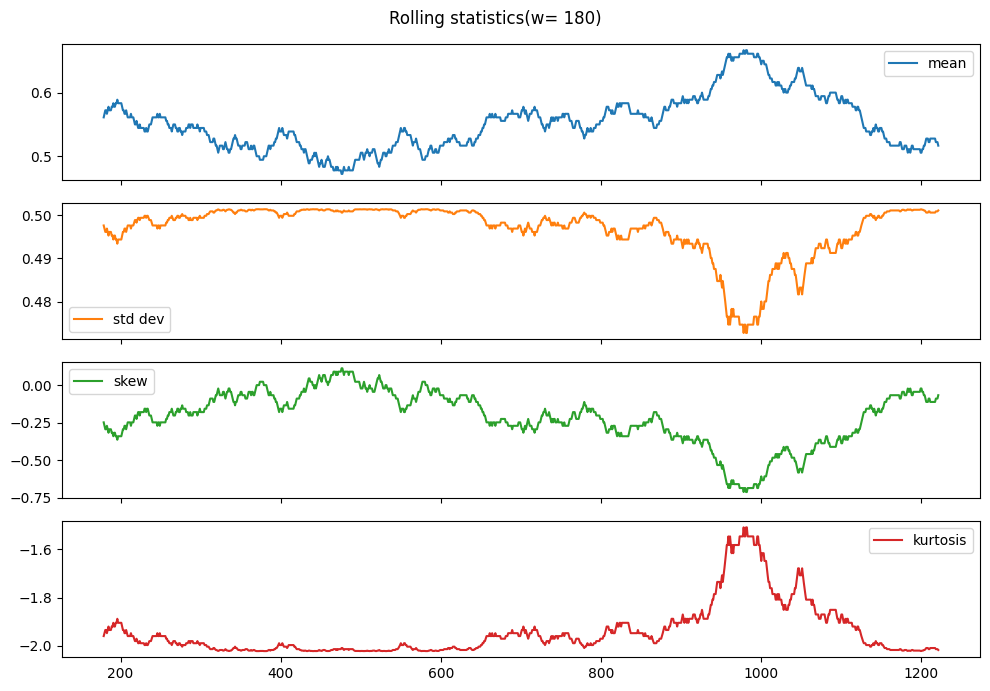

In [25]:
#Higher moments
data_lr = data['target']

w= 180

for x in range(0, len(data_lr), len(data_lr)):
    start = x
    end = x + len(data_lr)
    temp = data_lr[(data_lr.index >= start) & (data_lr.index  < end)]  

    s1 = temp.rolling(w).mean()
    s2 = temp.rolling(w).std()
    s3 = temp.rolling(w).skew()  #skewedness = 0
    s4 = temp.rolling(w).kurt()  #kurtosis = 3  
    signals = pd.concat([s1, s2, s3, s4], axis=1)
    signals.columns = ['mean', 'std dev', 'skew', 'kurtosis']
    signals.plot(title="Rolling statistics(w= "+ str(w) + ")", subplots=True, figsize=(10,7));
    plot.tight_layout()
    plot.show

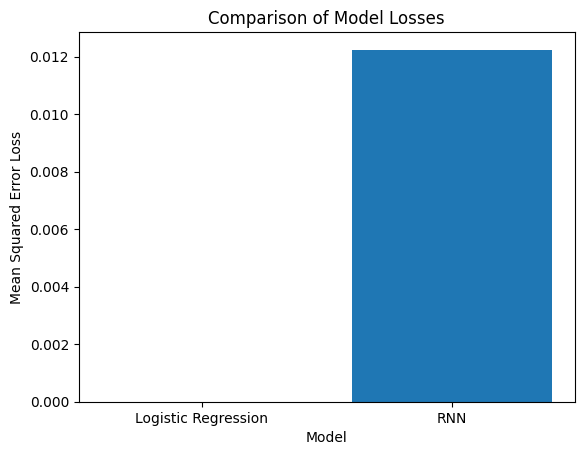

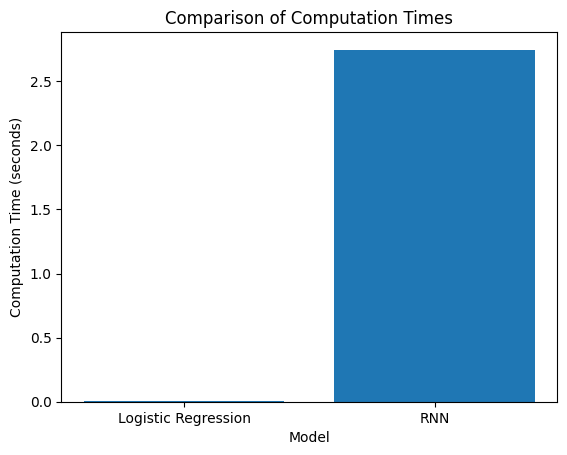

In [18]:
# Define the model losses and computation times
model_names = ['Logistic Regression', 'RNN']

losses = [lr_mse, rnn_mse]
times = [lr_time, rnn_time]

# Plot the model losses
#plot.figure(figsize=(10, 6))
plot.figure()
plot.bar(model_names, losses)
plot.xlabel('Model')
plot.ylabel('Mean Squared Error Loss')
plot.title('Comparison of Model Losses')
plot.show()

# Plot the computation times
#plot.figure(figsize=(10, 6))
plot.figure()
plot.bar(model_names, times)
plot.xlabel('Model')
plot.ylabel('Computation Time (seconds)')
plot.title('Comparison of Computation Times')
plot.show()

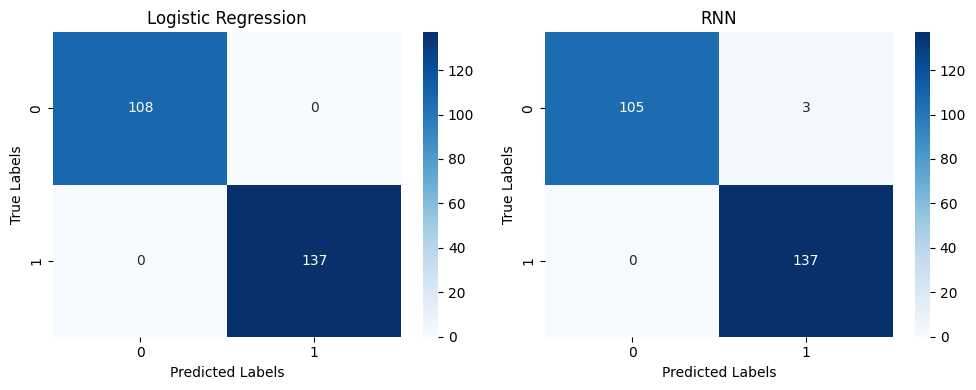

In [16]:
# Plot Confusion Matrix
fig, axes = plot.subplots(1, 2, figsize=(10, 4))

sns.heatmap(lr_confusion_matrix, annot=True, cmap='Blues', fmt='d', ax=axes[0])
axes[0].set_title('Logistic Regression')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(rnn_confusion_matrix, annot=True, cmap='Blues', fmt='d', ax=axes[1])
axes[1].set_title('RNN')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

plot.tight_layout()
plot.show()

8/8 [==============================] - 0s 2ms/step


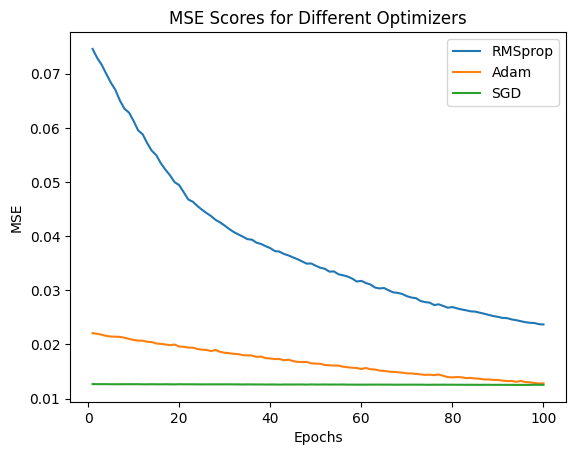

RMSprop: MSE = 0.02994831376054728
Adam: MSE = 0.017544581396361555
SGD: MSE = 0.017547031125278525


In [22]:

# Define the sequence length for RNN and LSTM
sequence_length = 60  # Adjust this as needed

# Define the RNN model
model = Sequential()
model.add(SimpleRNN(32, input_shape=(sequence_length, 1)))
model.add(Dense(1))

# Compile the model with different optimizers
optimizers = {
    'RMSprop': RMSprop(),
    'Adam': Adam(),
    'SGD': SGD()
}

mse_scores = {}

# Train and evaluate the model with different optimizers
for optimizer_name, optimizer in optimizers.items():
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_scores[optimizer_name] = mse
    
    # Plot MSE scores
    plot.plot(np.arange(1, len(history.history['loss']) + 1), history.history['loss'], label=optimizer_name)

# Add labels and title to the plot
plot.xlabel('Epochs')
plot.ylabel('MSE')
plot.title('MSE Scores for Different Optimizers')
plot.legend()

# Show the plot
plot.show()

# Print the MSE scores for each optimizer
for optimizer_name, mse in mse_scores.items():
    print(f'{optimizer_name}: MSE = {mse}')

